### Image Classification - Number vs No Number

> In lesson1 v2 of fast.ai, we learned "cats vs dogs" image classification.  The probability of the image being a cat or a dog.  In this notebook, I set to replicate lesson1 and create an image classifier that recognizes pictures with or without number.   The sample datasets are collected from "Street View Home Number" and "Cifar10" datasets.<br>

***Reminder***<br>
1) Follow advises from Jeremy Howard(lecture), Leslie Smith(hyperameter tunning paper), Andrej Karpath(Twitter).<br> 
2) Interact quickly, leave what doesn't work(or unanswered questions) for later.<br>
3) Experiment and take notes of what you are doing different each time.  Make it readable to simple audience.<br>
4) Study the data: image size, resolution, etc. <br>
5) Start small and make sure the pipeline works before training the entire datasets.<br>

***Steps learned from lesson1***
1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from shutil import copyfile

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))



In [6]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [7]:
# Create "number" datasets paths. 
PATH = 'data/numbers/'

# 1) SVHN sample datasets already exist.
# 2) data/numbers/ directory already exist.
# 3) Use f-strings to name paths.

In [8]:
os.listdir(f'{PATH}') 

['models', 'train', 'valid', 'tmp', 'test']

In [9]:
os.listdir(f'{PATH}/train')

['nonumber', 'number']

In [10]:
os.listdir(f'{PATH}/valid')

['nonumber', 'number']

In [11]:
# Print specific file type, file q'ty in a folder, and file names. 
def folder_inf(folder, formato):
    file_names = []
    for i in folder.rglob(formato):
        s = i.name
        file_names.append(s)
    print('Total number of images(type {}) in folder "{}" is "{}".'.format(formato, folder,
                                                                           len(file_names)))
    return(file_names)

# Shuffle files randomly within a folder.
def shuf_folder(folder, formato):
    shuf = []
    for i in folder.rglob(formato):
        s = i.name
        shuf.append(s)
    random.shuffle(shuf)
    return(shuf)

# Copy from source to target folder
def copy_f1tof2(tocopy, source, target):
    for i in range(len(tocopy)):
        copyfile(str(source/tocopy[i]), str(target/tocopy[i]))

In [12]:
# Create access to Cifar10, copy randomly 12 images from each category and paste to
#   101 images to "data/numbers/train/nonumber" and 21 to "data/numbers/val/nonumber"
C = Path('data/cifar10/train')
c10_cat = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship',
          'truck']
for i in range(len(c10_cat)):
    source = (C/f'{c10_cat[i]}/')
    shuf = shuf_folder(source, '*.png*')
    train_no = shuf[0:10]
    val_no = shuf[10:12]
    train_nonum = Path(f'{PATH}train/nonum') 
    val_nonum = Path(f'{PATH}valid/nonum')
    #copy_f1tof2(train_no, source, train_nonum)
    #copy_f1tof2(val_no, source, val_nonum)

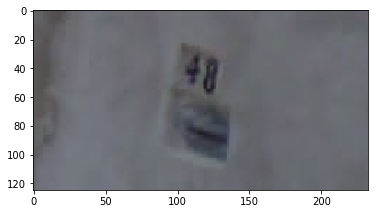

In [13]:
# Images from "valid/number" folder:
files = os.listdir(f'{PATH}/valid/number/')[:5]
img = plt.imread(f'{PATH}/valid/number/{files[0]}')
plt.imshow(img);

In [14]:
img.shape

(125, 233, 3)

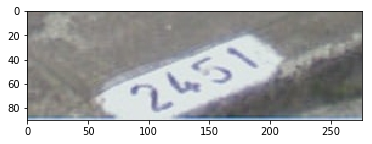

In [15]:
# Images from "train/number" folder:
files_1 = os.listdir(f'{PATH}/train/number/')[:5]
img_1 = plt.imread(f'{PATH}/train/number/{files_1[0]}')
plt.imshow(img_1)

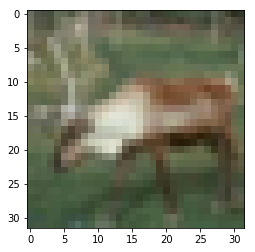

In [16]:
# Images from "valid/nonumber" folder:
files = os.listdir(f'{PATH}/valid/nonumber/')[:5]
img_2 = plt.imread(f'{PATH}/valid/nonumber/{files[0]}')
plt.imshow(img_2);

In [17]:
img_2.shape

(32, 32, 3)

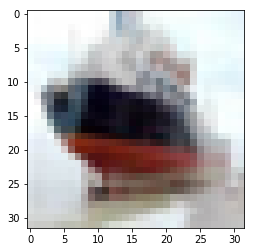

In [18]:
# Images from "train/nonumber" folder:
files_1 = os.listdir(f'{PATH}/train/nonumber/')[:5]
img_3 = plt.imread(f'{PATH}/train/nonumber/{files_1[0]}')
plt.imshow(img_3)

In [19]:
os.listdir(f'{PATH}/train/nonumber')[0:5]
# Note: The current image names contains names ship, bird, etc.  Should I rename them to
#   'nonumber_2438.png', 'nonumber_5384.png', etc.?

['2438_ship.png',
 '5384_bird.png',
 '19289_truck.png',
 '13178_horse.png',
 '40315_truck.png']

In [20]:
os.listdir(f'{PATH}/train/number')[0:5]
# Note: Should I rename them to 'number_2438.png', 'number_5384.png', etc.?

['32934.png', '14893.png', '11264.png', '31961.png', '21096.png']

#### **Initial Setting**:
Follow settings from first part of lesson1<br>
1) arch = Resnet34(pretrained Imagenet)<br>
2) sz = 32<br>
3) bs = 64(default)<br>
4) lr = 0.01 <br>
5) epoch = 2 <br>
6) precompute = True<br>
7) data augmentation = False<br> 
8) images in folders:<br>
"train/nonumber" = 100 (Cifar10) <br>
"train/number" = 100 (SVHN)<br>
"valid/nonumber" = 20 (Cifar10)<br>
"valid/number" = 20 (SVHN)<br>
9) label naming: ex. "xxxx_ship.png" for nonumber; "xxxx.png" for number. 

In [21]:
arch = resnet34
sz = 32

data = ImageClassifierData.from_paths(PATH, tfms = tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute = True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                
    0      0.647015   0.337969   0.85      
    1      0.40893    0.114946   0.95            



[array([0.11495]), 0.949999988079071]

In [22]:
learn.lr_find()

epoch      trn_loss   val_loss   accuracy         
    0      0.108477   0.077324   0.95      



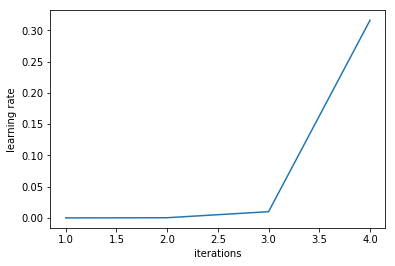

In [23]:
learn.sched.plot_lr()

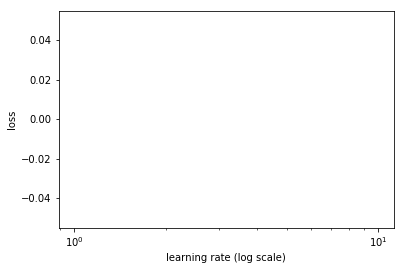

In [24]:
learn.sched.plot() # Not printing any graphic?

In [25]:
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [26]:
data.classes

['nonumber', 'number']

In [27]:
# Validation datasets, 20 images from nonumber and 20 from number.
log_preds = learn.predict()
log_preds.shape

(40, 2)

In [28]:
log_preds[:10]

array([[-0.02316, -3.77704],
       [-0.00599, -5.12039],
       [-0.00089, -7.03011],
       [-0.03132, -3.47901],
       [-0.00043, -7.74407],
       [-0.20276, -1.69541],
       [-0.0146 , -4.23392],
       [-0.0013 , -6.64822],
       [-0.04338, -3.15932],
       [-0.01999, -3.92263]], dtype=float32)

In [29]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1]) # pr that it is a number    

Correctly classified


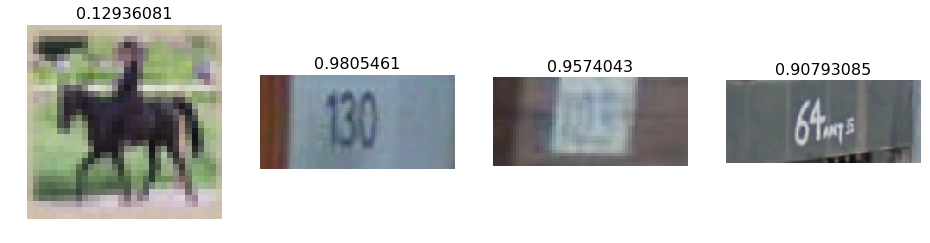

In [30]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [31]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

ValueError: Cannot take a larger sample than population when 'replace=False'

Most correct nonumber


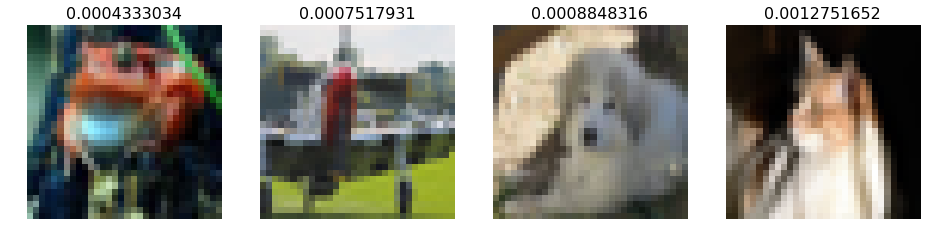

In [32]:
plot_val_with_title(most_by_correct(0, True), "Most correct nonumber")

Most correct number


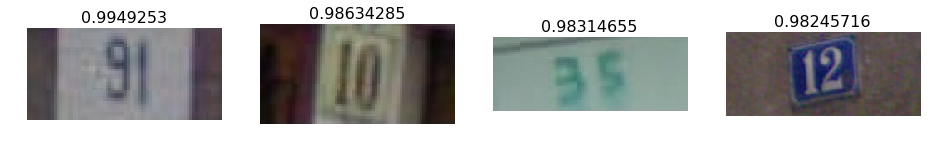

In [33]:
plot_val_with_title(most_by_correct(1, True), "Most correct number")

In [34]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect nonumber")

Most incorrect nonumber


<Figure size 1152x576 with 0 Axes>

Most incorrect number


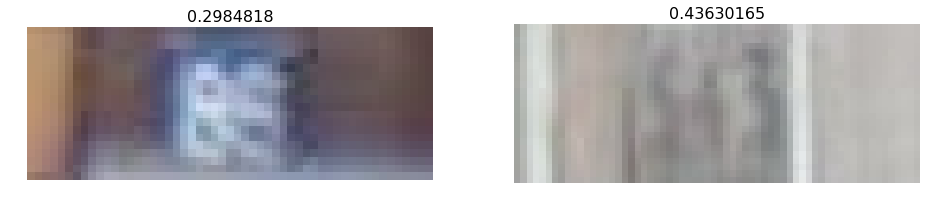

In [35]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect number")

Most uncertain predictions


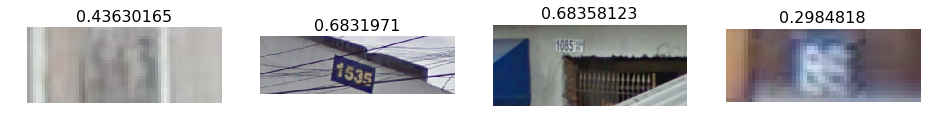

In [36]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

From the previous initial setting, I've verified that the pipeline works.  In this second setting, I try to answer the following:<br>
1) With different label naming, does the result improves.<br>
2) What are the improvement when:<br>
2.1) Increase the size of the dataset 10x.<br>
2.2) Add data augmentation.<br>
2.3) Use lr finder.<br>
2.4) Train previous layers(not only the last layers).<br><br>


#### **Settings 1**:<br>
1) arch = Resnet34(pretrained Imagenet)<br>
2) sz = 32<br>
3) bs = 18<br>
4) lr = 0.01(start); lr = (lr finder)<br>
5) epoch = 2<br>
6) precompute = True(start), precompute = False (train all layers)<br>
7) data augmentation = True <br> 
8) images in folders:<br>
"numbers_1000/train1000/nonumber" = 1000 (Cifar10) <br>
"numbers_1000/train1000/number" = 1000 (SVHN)<br>
"numbers_1000/valid1000/nonumber" = 200 (Cifar10)<br>
"numbers_1000/valid1000/number" = 200 (SVHN)<br>  

In [37]:
PATH = 'data/numbers_1000/'
# Create dirs for 'train_1000/nonnumber_1000', "train_1000/number_1000", 
# "valid_1000/nonumber_1000", "valid_1000/number_1000" -> already exist.

In [38]:
# Create 'train_1000/nonumber_1000 datasets'
# Create 'valid_1000/nonumber_1000 datasets'
# Create access to Cifar10, copy randomly 120 images from each category and paste
#   1000 images to "data/numbers/train_1000/nonumber_1000" and 200 to "data/numbers/val_1000/nonumber"_1000
C = Path('data/cifar10/train')
c10_cat = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship',
          'truck']
for i in range(len(c10_cat)):
    source = (C/f'{c10_cat[i]}/')
    shuf = shuf_folder(source, '*.png*')
    train_no = shuf[0:100]
    val_no = shuf[100:120]
    train_nonum1000 = Path(f'{PATH}train1000/nonumber')
    val_nonum1000 = Path(f'{PATH}valid1000/nonumber')
    #copy_f1tof2(train_no, source, train_nonum1000)
    #copy_f1tof2(val_no, source, val_nonum1000)

In [39]:
# Create 'train_1000/number_1000 datasets' and 'valid_1000/number_1000' datasets.
source = Path('data/svhn/train')
shuf = shuf_folder(source, '*.png*')
train_no = shuf[0:1000]
val_no = shuf[1000:1200]
train_num1000 = Path(f'{PATH}train1000/number')
val_num1000 = Path(f'{PATH}valid1000/number')
#copy_f1tof2(train_no, source, train_num1000)
#copy_f1tof2(val_no, source, val_num1000)

In [40]:
# Check if files has been created in 'train_1000/num_1000'.
folder_inf(train_num1000, '*.png*')[0:5]

Total number of images(type *.png*) in folder "data/numbers_1000/train1000/number" is "1000".


['18569.png', '12985.png', '6225.png', '1962.png', '33027.png']

In [41]:
# Check if files has been created in 'val_1000/num_1000'.
folder_inf(val_num1000, '*.png*')[0:5]

Total number of images(type *.png*) in folder "data/numbers_1000/valid1000/number" is "200".


['19997.png', '28307.png', '20891.png', '20622.png', '12807.png']

In [42]:
# Check if files has been created in 'train_1000/nonum_1000'.
folder_inf(train_nonum1000, '*.png*')[0:5]

Total number of images(type *.png*) in folder "data/numbers_1000/train1000/nonumber" is "1000".


['3293_dog.png',
 '29493_ship.png',
 '22107_bird.png',
 '31579_deer.png',
 '43238_deer.png']

In [43]:
# Check if files has been created in 'valid_1000/nonum_1000'.
folder_inf(val_nonum1000, '*.png*')[0:5]

Total number of images(type *.png*) in folder "data/numbers_1000/valid1000/nonumber" is "200".


['1157_dog.png',
 '40371_bird.png',
 '4375_bird.png',
 '23976_dog.png',
 '14944_horse.png']

In [44]:
arch = resnet34
sz = 32
bs = 8
data = ImageClassifierData.from_paths(PATH, bs = bs, tfms = tfms_from_model(arch, sz),
                                      trn_name = 'train1000', val_name = 'valid1000')
learn = ConvLearner.pretrained(arch, data, precompute = True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.281332   0.10483    0.9725    
    1      0.261296   0.105257   0.9525                       



[array([0.10526]), 0.9525]

In [45]:
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 

In [46]:
data.classes

['nonumber', 'number']

In [47]:
log_preds = learn.predict()
log_preds.shape

(400, 2)

In [48]:
log_preds[0:10]

array([[ -0.24854,  -1.51384],
       [ -0.00017,  -8.70009],
       [ -0.     , -13.54456],
       [  0.     , -15.37476],
       [ -0.00946,  -4.66535],
       [ -0.00003, -10.46619],
       [  0.     , -15.22505],
       [ -0.00007,  -9.59972],
       [ -0.00025,  -8.30065],
       [  0.     , -23.32764]], dtype=float32)

In [49]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

Correctly classified


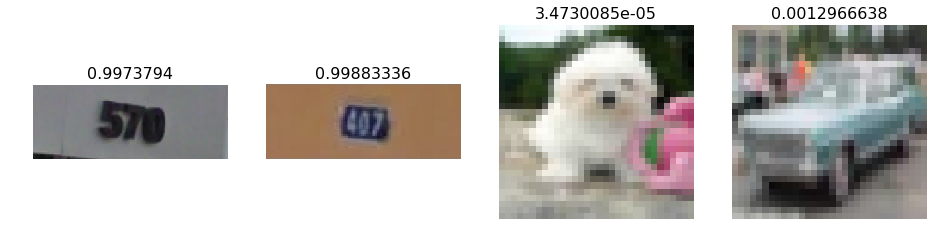

In [50]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


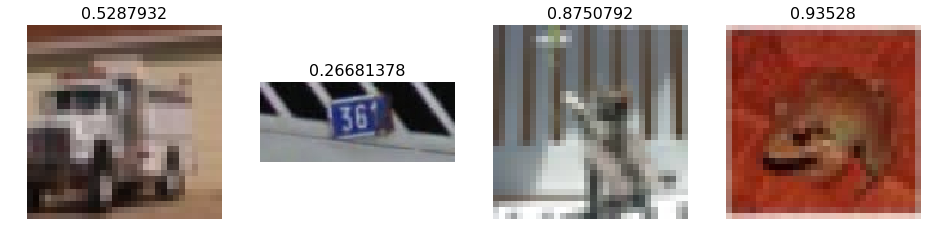

In [51]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Most correct nonumber


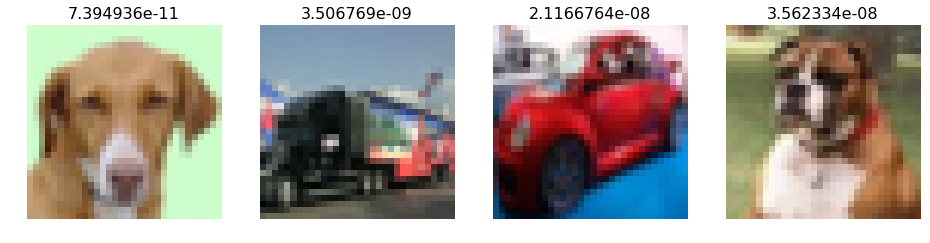

In [52]:
plot_val_with_title(most_by_correct(0, True), "Most correct nonumber")

Most correct number


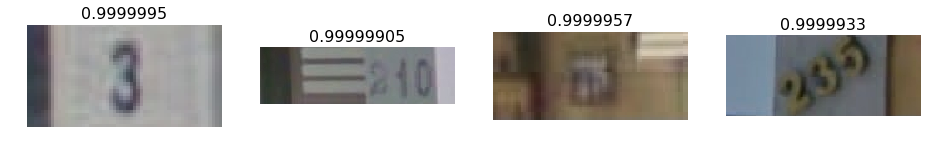

In [53]:
plot_val_with_title(most_by_correct(1, True), "Most correct number")

Most incorrect nonumber


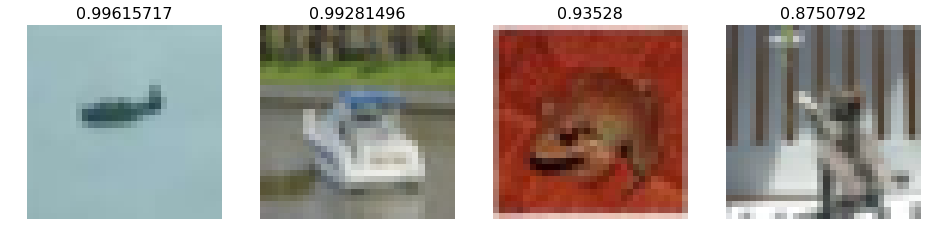

In [54]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect nonumber")

Most incorrect number


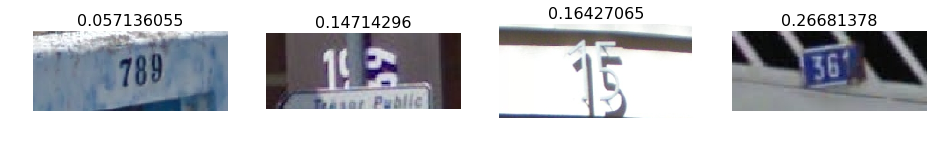

In [55]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect number")

Most uncertain predictions


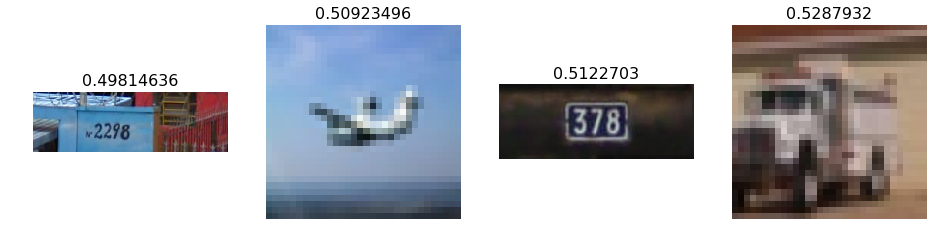

In [56]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [57]:
lr = learn.lr_find()

 62%|██████▏   | 156/250 [00:00<00:00, 253.96it/s, loss=0.636]


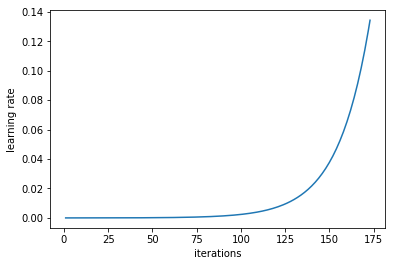

In [58]:
learn.sched.plot_lr()

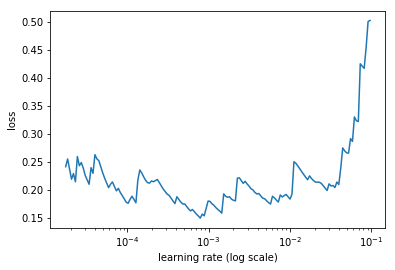

In [59]:
learn.sched.plot()

In [65]:
# Use data augmentation
tfms = tfms_from_model(resnet34, sz, aug_tfms = transforms_side_on, max_zoom = 1.1)

In [67]:
data = ImageClassifierData.from_paths(PATH, bs = bs, tfms = tfms,
                                      trn_name = 'train1000', val_name = 'valid1000')
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [68]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.280919   0.083107   0.9775    



[array([0.08311]), 0.9775]

In [69]:
learn.precompute = False

In [70]:
learn.fit(1e-2, 3, cycle_len = 1 )

epoch      trn_loss   val_loss   accuracy                     
    0      0.240583   0.058991   0.9775    
    1      0.238158   0.058058   0.98                        
    2      0.269364   0.058613   0.9775                      



[array([0.05861]), 0.9775]

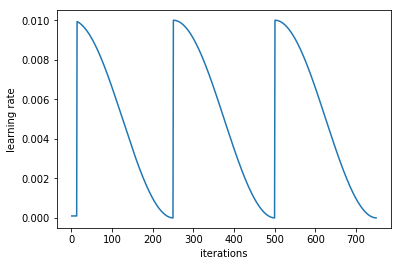

In [71]:
learn.sched.plot_lr()

In [72]:
learn.save('32_lastlayer_numbers_1000')

In [73]:
learn.load('32_lastlayer_numbers_1000')

In [74]:
learn.unfreeze()

In [75]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [79]:
# Accuracy improved, it is overfitting.
learn.fit(lr, 2, cycle_len = 3, cycle_mult = 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.374157   0.160351   0.9525    
    1      0.218552   0.107916   0.98                        
    2      0.15117    0.1137     0.97                        
    3      0.207885   0.379623   0.91                        
    4      0.116536   0.177167   0.9525                      
    5      0.103434   0.157375   0.96                        



[array([0.15738]), 0.96]

In [77]:
learn.save('32_lastlayer_numbers_1000_all')

In [78]:
learn.load('32_lastlayer_numbers_1000')

In [80]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [81]:
accuracy_np(probs, y)

0.9625

#### To be continued with Confusion Matrix

#### Lesson's Learned
i) Use variable "PATH" when using function "ImageClassifierData.from_paths(PATH)".  When I used another variable name, for ex. "PATH_1", it did not find the correct paths.<br>
ii) Follow the same path naming rules for the entire notebook.  If you start with f-strings "f'{PATH}/train'", for example, use it all the way.  If for some reason you use both f-strings and pathlib, it can create confusion.<br>
iii) Diminish the bs when your datasets are small.  'learn.sched.plot()' will not plot until when you set bs lower.<br>
iv) When you change folder names or variable settings, ex. train, valid, test, or bs, make sure you add this changes to ImageClassifierData.from_paths() as well.<br>
iv) Starting with samples of 100(train) and 20(valid), is probably the same as starting with 1000(train) and 200(valid).  Start with the ladder next time, it won't make much difference in training time. 


#### Questions:
a) How do you perform inference with 'testing'?<br>
b) How do you know when the weights are from Imagenet?<br>
c) Other than image size, what other characteristics should you analyze from the image?<br>
d) A 'tmp' folder was created with "x_act_resnet34_0_32.bc", "x_act_resnet34_0_32.bc", and "x_act_val_resnet34_0_32.bc".  What are they and why were they created? <br>
e) A 'model' folder was created with 'tmp.h5'.  What is it for? <br>
f) How to find the image size and resolution using fastai library? <br>
g) Does the resolution matter or only the size? <br>
h) What would happen if you only train SVHN datasets from scratch? <br>
i) Instead of using Cifar10 datasets as "nonumber" images, if I change the datasets to "street sign or post" images, but without any number.  Would this type of images has more resemblance with "Street View House Number" images, and therefore improve its accuracy?<br>

***The above questions will be replied in the coming updates**.


